In [1]:
from math import e, factorial,log, gamma, sqrt, floor
from matplotlib import pyplot as pt
from numpy.random import geometric,exponential,poisson
from scipy.stats import ks_2samp
from scipy.stats import norm
from numpy import linspace
from IPython.display import Markdown
from analysis import *
from threading import Thread

In [2]:
pt.rcParams["figure.figsize"] = (20,10)

# Load data

This is a comment


In [3]:
Ttx = 30
Trx = 60
Tn = 100
    
def compute_histogram(r1,r2):

    Eb1,Es1,En1 = computeEvents(r1,Ttx,Trx,Tn)
    Eb2,Es2,En2 = computeEvents(r2,Ttx,Trx,Tn)
    display(Markdown('<span style="color: #af0000">'+"P(S) = %.6f"%(Trx*Es1/len(r1))+'</span>'))
    display(Markdown('<span style="color: #00af00">'+"P(N) = %.6f"%(Tn*En1/len(r1))+'</span>'))
    display(Markdown('<span style="color: #0000af">'+"P(B) = %.6f"%(Ttx*Eb1/len(r1))+'</span>'))

    Pb2 = Eb2*Ttx/(Eb2*Ttx+En2*Tn+Es2*Trx)
    rt1 = Pb2/(Ttx/1000)
    
    print("r(B)(Events/s) = %.6f"%(rt1))
    
    hist1 = genWindowHistogram(r1,r2,1000)
    Esuc = checkSuccess(r2,r1)
    Ps=Esuc/Eb2
    rs2 = Esuc*1000/len(r1)
    print("r(Suuccess)(Events/s) = %.6f"%rs2)
    Pscan = Trx*Es1/len(r1)
    r_scan = 1000*Pscan/Trx
    print("r(S)(Events/s) = %.6f"%r_scan)
    Ns = Ps*1000/Ttx
    Nb = rt1*1000
    print("Success probability evts: %.6f"%(Ps))
    return hist1,Eb1,Es1,En1,Ps

<span style="color: #af0000">P(S) = 0.500140</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.499860</span>

r(B)(Events/s) = 16.667159
1.0
r(Suuccess)(Events/s) = 8.333480
r(S)(Events/s) = 8.335659
Success probability evts: 0.500045
0.9991400816922392
---------------------


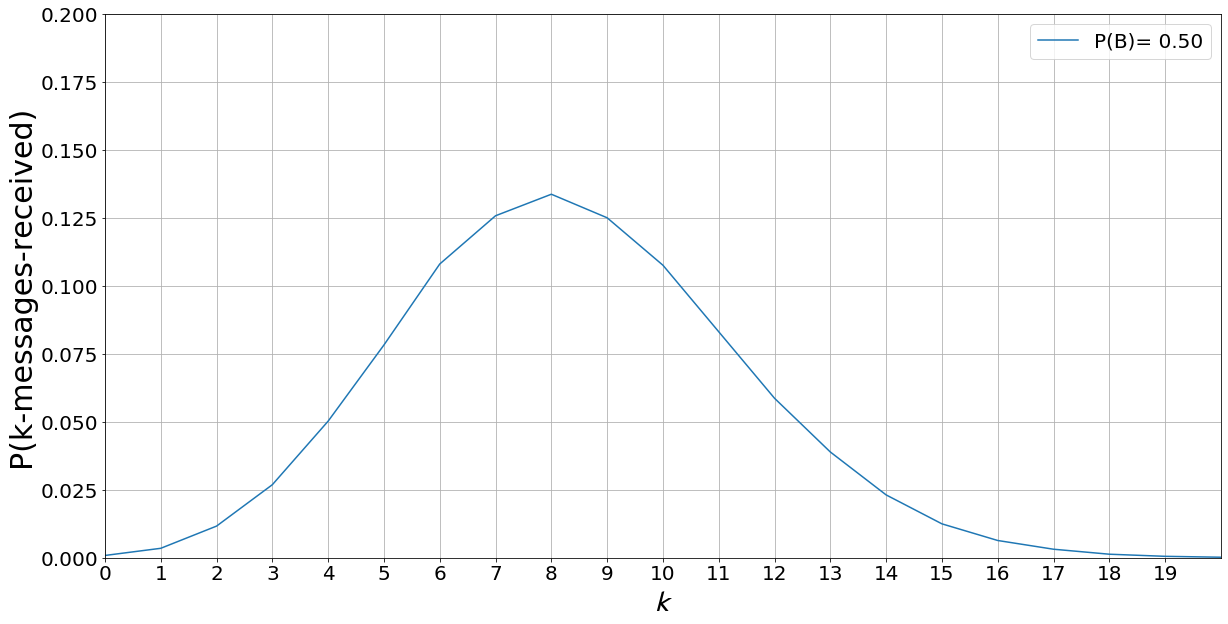

In [9]:
leg = [20,30,40,50,60,70,80,90]
for i in range(1,9):
    if i != 4:
        continue
    f1 = open("r%d-d0-result.txt"%i)
    raw1 = f1.read()
    f1.close()

    f2 = open("r%d-d1-result.txt"%i)
    raw2 = f2.read()
    f2.close()

    hist,Eb,Es,En,Ps = compute_histogram(raw1,raw2)
    print(1-hist[0])
    print('---------------------')
    if (10+i*10) in [50]:
        pt.plot(range(len(hist)),hist,label="P(B)= %.2f"%((10+i*10)/100))
    del(hist)
    
pt.axis([0,20,0,0.2])
pt.xticks(range(20), [str(n) for n in range(20)],fontsize=20)
pt.yticks(fontsize=20)
pt.xlabel(r'$\mathcal{k}$', fontsize = 30)
pt.ylabel(r'P(k-messages-received)', fontsize = 30)
pt.legend(fontsize=20)
pt.grid(True)
pt.savefig('arrival_distribution.pdf',format='pdf',dpi=300, bbox_inches='tight')
pt.show()